In [1]:
import sys, os, re
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

import torch
print("PyTorch:", torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import pytorch_lightning as pl

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D

# from esm.models.esmc import ESMC
# from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /zhome/c9/0/203261/miniconda3/envs/esm_gpu/bin/python
PyTorch: 2.5.1
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


first you need to run `02_ESMC_encoding_some_PDB_seqs.ipynb` to generate ESM_C encodings for some of the proteins from PPint

In [2]:
PPint_DB_encodings_list = os.listdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/ESM_C_embeddings")
encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/ESM_C_embeddings"
PPint_DB_embedings = []
for file in PPint_DB_encodings_list:
    path = os.path.join(encodings_path, file)
    embedding = np.load(path)[0]
    PPint_DB_embedings.append(embedding)

In [3]:
meta_binders_encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/binders_embeddings"
meta_binders_files = sorted(os.listdir(meta_binders_encodings_path))  # keep files & embeddings aligned
meta_binders_embedings = [np.load(os.path.join(meta_binders_encodings_path, f))[0] for f in meta_binders_files]

In [4]:
meta_targets_embedings_list = os.listdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings")
encodings_path = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/meta_analysis/targets_embeddings"
meta_targets_embedings = []
for file in meta_targets_embedings_list:
    path = os.path.join(encodings_path, file)
    embedding = np.load(path)[0]
    meta_targets_embedings.append(embedding)

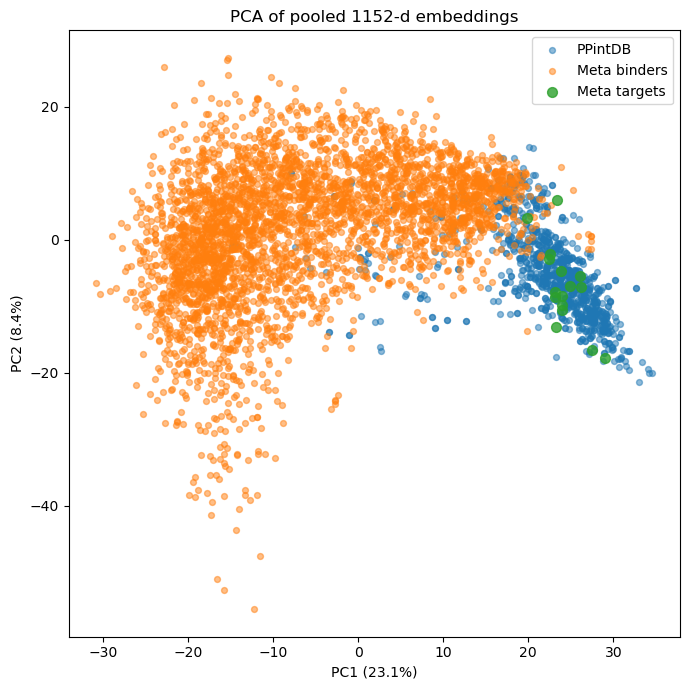

In [9]:
# 1) Pool per-sample (mean over residues) -> (Ni, 1152)
pooled_PPintDB       = np.stack([arr.mean(axis=0) for arr in PPint_DB_embedings], axis=0)        # (N1, 1152)
pooled_meta_binders  = np.stack([arr.mean(axis=0) for arr in meta_binders_embedings], axis=0)    # (N2, 1152)
pooled_meta_targets  = np.stack([arr.mean(axis=0) for arr in meta_targets_embedings], axis=0)    # (N3, 1152)

# 2) Standardize jointly (important!)
X_all = np.vstack([pooled_PPintDB, pooled_meta_binders, pooled_meta_targets])  # (N1+N2+N3, 1152)
X_all_std = StandardScaler().fit_transform(X_all)

# 3) PCA on combined
pca = PCA(n_components=2, random_state=0)
Z_all = pca.fit_transform(X_all_std)  # (N1+N2+N3, 2)

# 4) Split back by counts
N1 = pooled_PPintDB.shape[0]
N2 = pooled_meta_binders.shape[0]
N3 = pooled_meta_targets.shape[0]

Z_PPintDB       = Z_all[:N1]
Z_meta_binders  = Z_all[N1:N1+N2]
Z_meta_targets  = Z_all[N1+N2:N1+N2+N3]   # or simply Z_all[N1+N2:]

# 5) Plot
plt.figure(figsize=(7,7))
plt.scatter(Z_PPintDB[:,0],      Z_PPintDB[:,1],      s=18, alpha=0.5, label="PPintDB",        marker='o')
plt.scatter(Z_meta_binders[:,0], Z_meta_binders[:,1], s=18, alpha=0.5, label="Meta binders",   marker='o')
plt.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=50, alpha=0.8, label="Meta targets",   marker='o')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_1329746/1709085208.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', len(meta_targets_embedings_list))


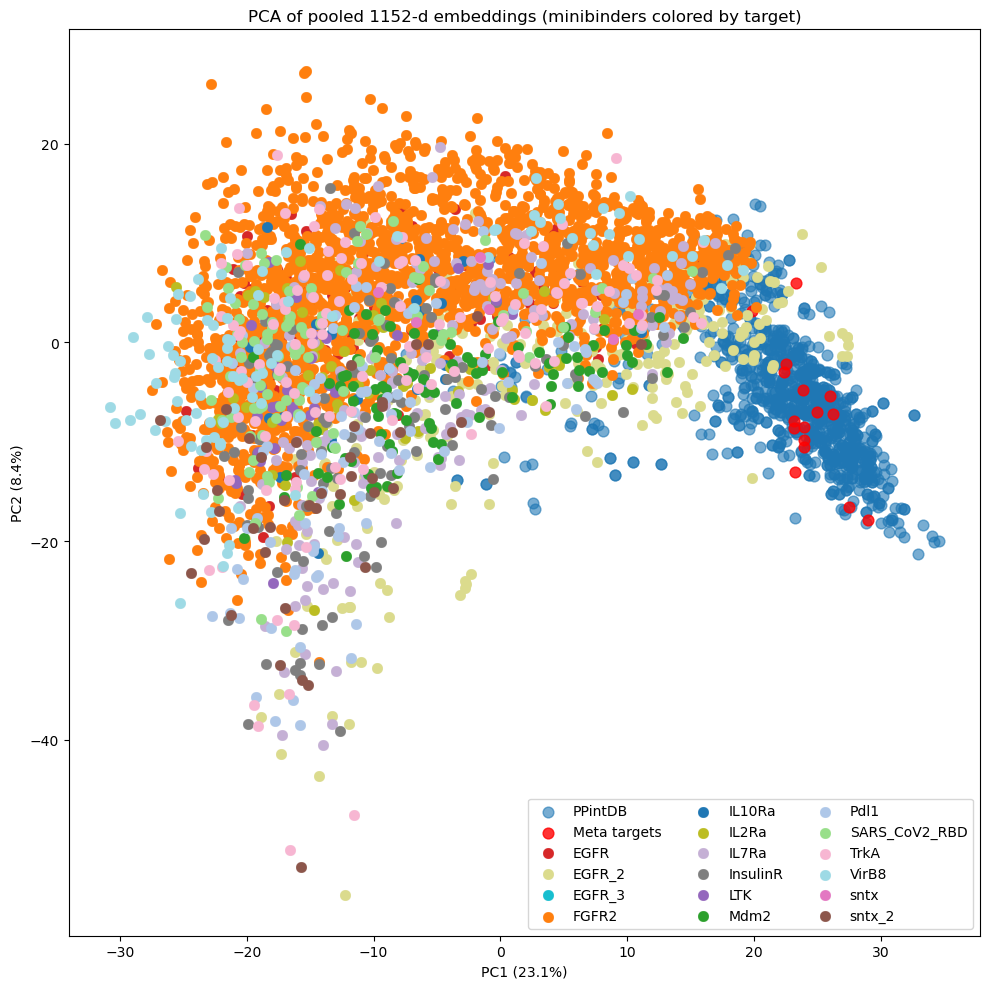

In [10]:
def target_from_filename(fname: str):
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r"^(.*)_(\d+)$", base)
    return m.group(1) if m else base

binder_targets = [target_from_filename(f) for f in meta_binders_files]

targets = [npy_file.split(".")[0] for npy_file in meta_targets_embedings_list]
cmap = get_cmap('tab20', len(meta_targets_embedings_list))
target2color = {t: cmap(i) for i, t in enumerate(targets)}
binder_colors = [target2color.get(t, (0.5,0.5,0.5,0.6)) for t in binder_targets]

from collections import defaultdict

plt.figure(figsize=(10,10))
plt.scatter(Z_PPintDB[:,0], Z_PPintDB[:,1], s=60, alpha=0.6, label="PPintDB", marker='o')
plt.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=60, alpha=0.8, label="Meta targets", color="red", marker='o')

groups = defaultdict(list)
for idx, t in enumerate(binder_targets):
    groups[t].append(idx)

for t, idxs in groups.items():
    plt.scatter(Z_meta_binders[idxs,0], Z_meta_binders[idxs,1], s=60, alpha=1, color=target2color[t], linewidth=0.2, label=t)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings (minibinders colored by target)")
plt.legend(ncol=3)
plt.tight_layout(); plt.show()


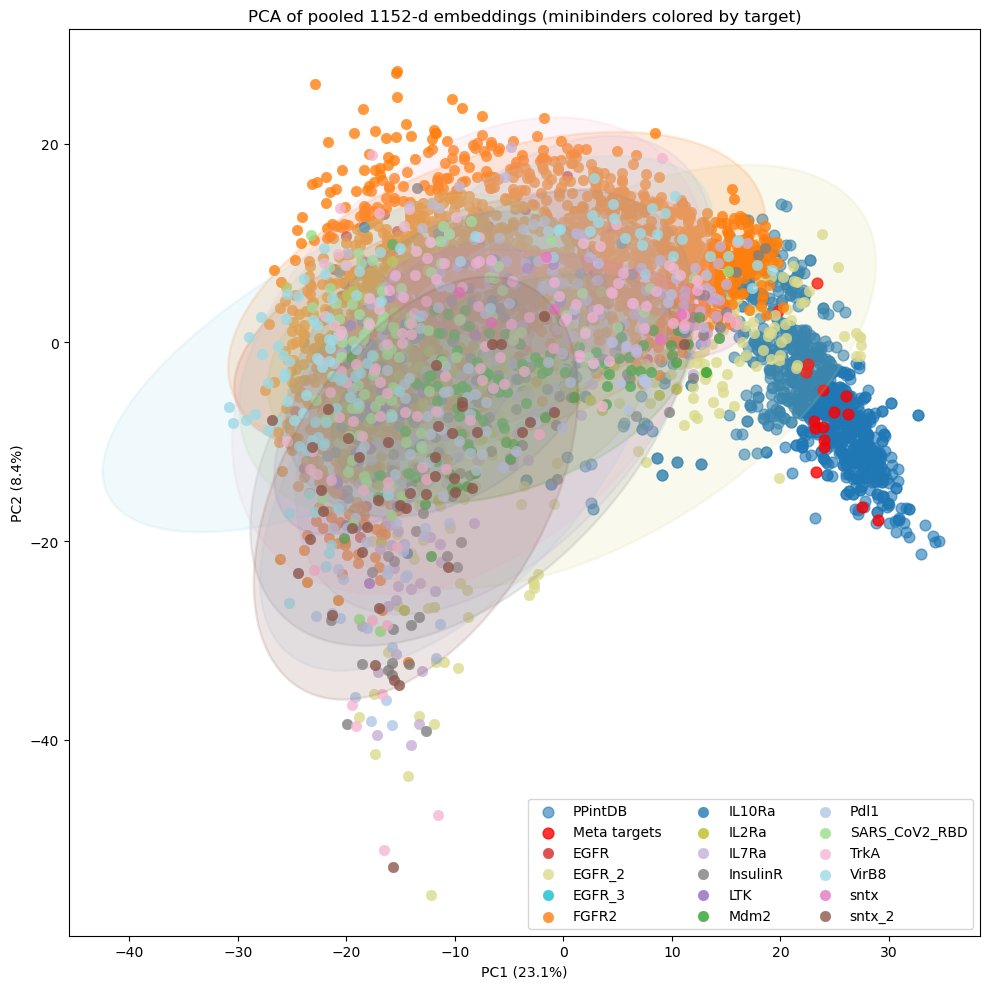

In [11]:
import numpy as np
from matplotlib.patches import Ellipse

def plot_cov_ellipse(ax, X, color, n_std=2.0, alpha=0.15, lw=1.5):
    """
    Draw an n-std covariance ellipse for 2D points X (N x 2).
    """
    if X.shape[0] < 2:
        return  # need at least 2 points

    # mean and 2x2 covariance
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)

    # eigen-decomposition (principal axes)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # angle of rotation (in degrees) from first eigenvector
    theta = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # width/height are 2*n_std*sqrt(eigenvalues)
    width, height = 2 * n_std * np.sqrt(np.maximum(vals, 0))

    ell = Ellipse(xy=mu, width=width, height=height, angle=theta,
                  facecolor=color if len(color)==4 else None,
                  edgecolor=color, linewidth=lw, alpha=alpha)
    ax.add_patch(ell)

# --- your plotting code ---
from collections import defaultdict
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Z_PPintDB[:,0], Z_PPintDB[:,1], s=60, alpha=0.6, label="PPintDB", marker='o')
ax.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=60, alpha=0.8, label="Meta targets", color="red", marker='o')

groups = defaultdict(list)
for idx, t in enumerate(binder_targets):
    groups[t].append(idx)

for t, idxs in groups.items():
    pts = Z_meta_binders[idxs, :2]
    ax.scatter(pts[:,0], pts[:,1], s=60, alpha=0.8, color=target2color[t], linewidth=0.2, label=t)
    # add a 2-sigma ellipse per cluster (tweak n_std/alpha to taste)
    plot_cov_ellipse(ax, pts, color=target2color[t], n_std=2.0, alpha=0.15, lw=1.8)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("PCA of pooled 1152-d embeddings (minibinders colored by target)")
ax.legend(ncol=3)
plt.tight_layout(); plt.show()


/tmp/ipykernel_1329746/4240625055.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20', len(set(labels)))


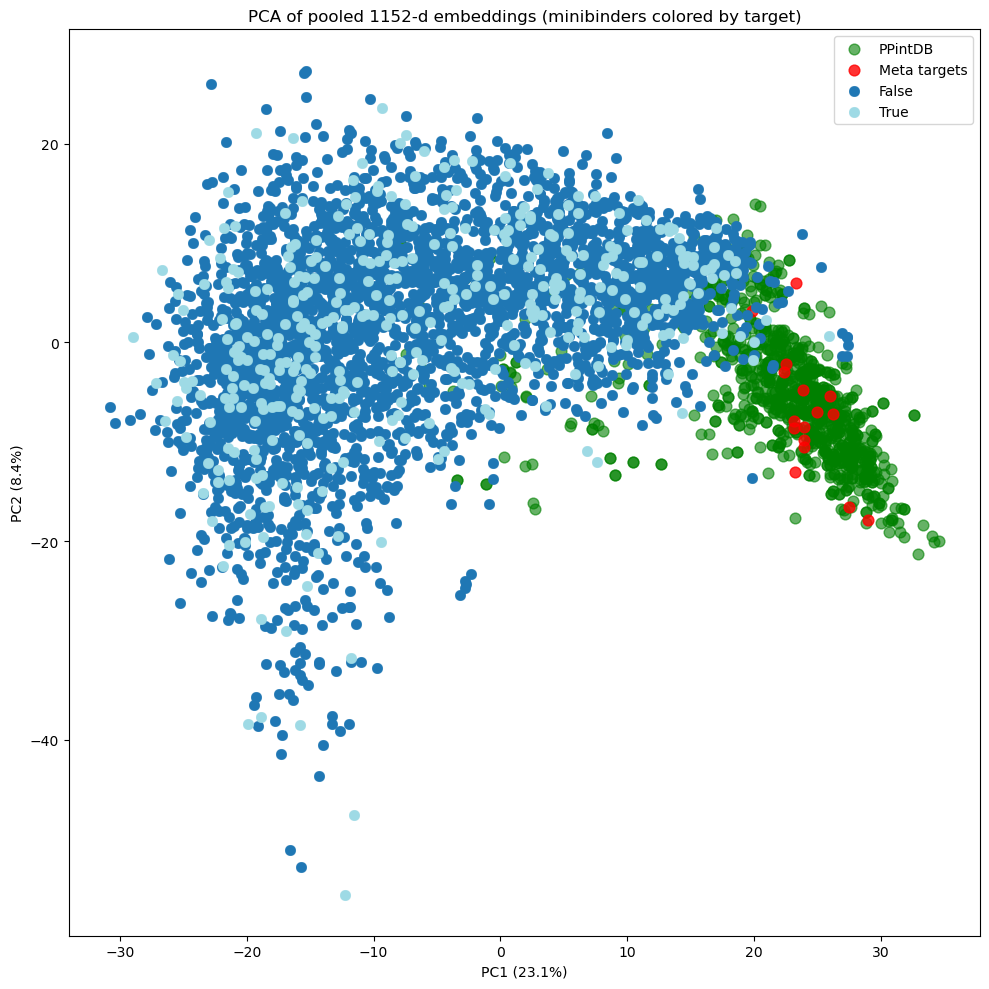

In [12]:
interaction_df = pd.read_csv("../data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
labels = np.asarray(interaction_df.binder).tolist()
cmap = get_cmap('tab20', len(set(labels)))
label2color = {t: cmap(i) for i, t in enumerate(set(labels))}
binder_colors = [target2color.get(t, (0.5,0.5,0.5,0.6)) for t in labels]

from collections import defaultdict

plt.figure(figsize=(10,10))
plt.scatter(Z_PPintDB[:,0], Z_PPintDB[:,1], s=60, alpha=0.6, label="PPintDB", marker='o', color="green")
plt.scatter(Z_meta_targets[:,0], Z_meta_targets[:,1], s=60, alpha=0.8, label="Meta targets", color="red", marker='o')

groups = defaultdict(list)
for idx, t in enumerate(labels):
    groups[t].append(idx)

for t, idxs in groups.items():
    plt.scatter(Z_meta_binders[idxs,0], Z_meta_binders[idxs,1], s=60, alpha=1, color=label2color[t], linewidth=0.2, label=t)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of pooled 1152-d embeddings (minibinders colored by target)")
plt.legend(ncol=1)
plt.tight_layout(); plt.show()